# Simple experiments to understand the motivation for OPE/L studies

In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.ope import InverseProbabilityWeighting as IPS, OffPolicyEvaluation
from obp.policy import IPWLearner
from obp.utils import sample_action_fast
from tqdm import tqdm

from utils import aggregate_simulation_results, visualize_mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting
beta=5.0
n_users=1000
n_actions=20
dim_context=10

In [3]:
dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    beta=beta
)
# generate synthetic data
data = dataset.obtain_batch_bandit_feedback(n_rounds=n_users)

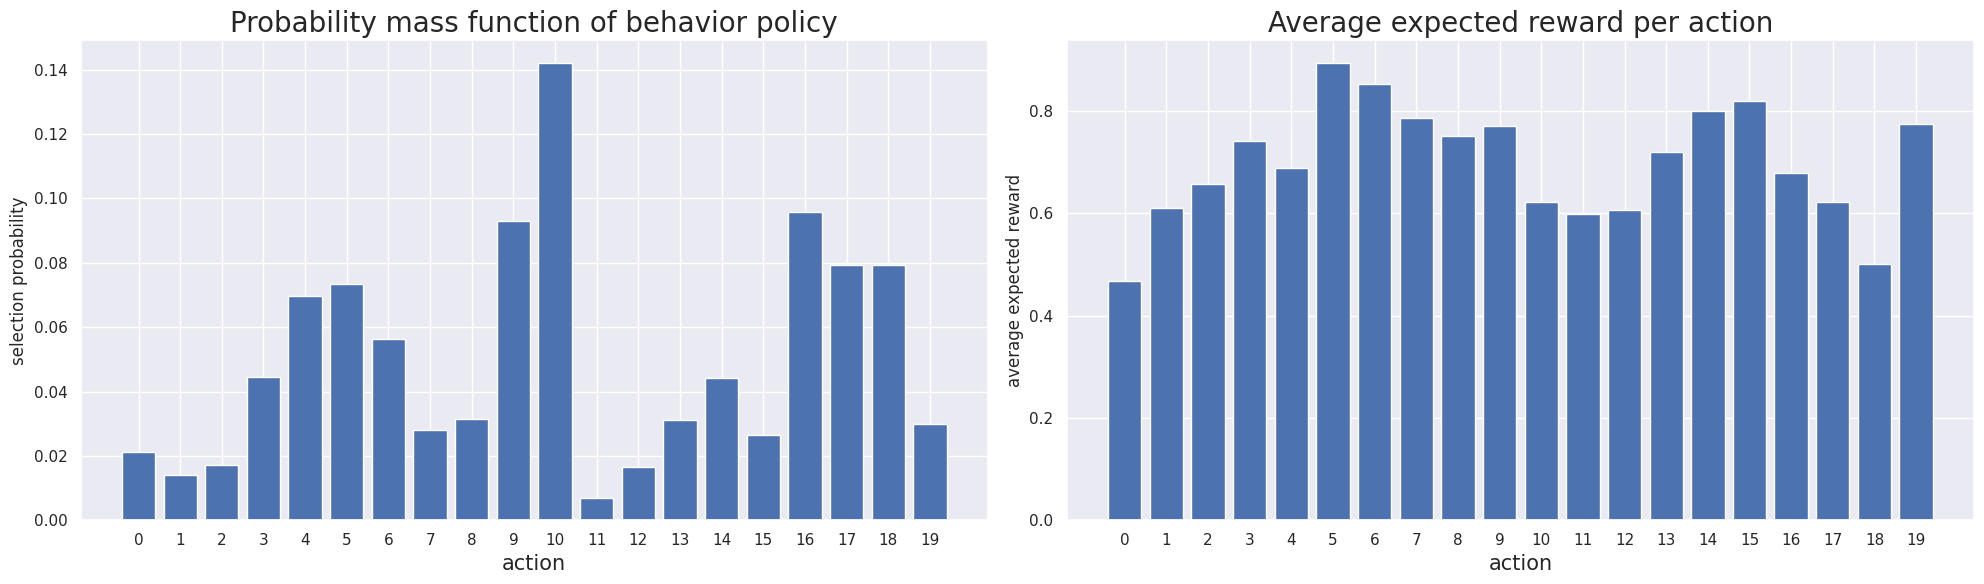

In [4]:
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
plt.title('Probability mass function of behavior policy', fontsize=20)
plt.bar(x=np.arange(n_actions), height=data["pi_b"][:,:,0].mean(0))
plt.xlabel('action', fontsize=15)
plt.ylabel('selection probability')
plt.xticks(np.arange(n_actions))

plt.subplot(1, 2, 2)
plt.title('Average expected reward per action', fontsize=20)
plt.bar(x=np.arange(n_actions), height=data["expected_reward"].mean(0))
plt.xlabel('action', fontsize=15)
plt.ylabel('average expected reward')
plt.xticks(np.arange(n_actions))

plt.tight_layout()
plt.show()


In [5]:
result_df_list = []
evaluation_policies = defaultdict(dict)

for estimator_name in ["Naive", "IPS"]:
    
    # aggregate the selected action by behavior policy 
    result_df = DataFrame()
    result_df["user"] = np.arange(n_users)
    result_df["action"] = data["action"]
    result_df["policy_name"] = "behavior_policy"
    result_df["estimator"] = estimator_name
    result_df_list.append(result_df)

    policies = {"LogisticRegression": LR(), "GradientBoost": GBC(learning_rate=0.01, n_estimators=10)}
    for policy_name, policy in policies.items():

        model = IPWLearner(
            n_actions=n_actions,
            base_classifier=policy
        )
        
        pscore = data["pscore"] if estimator_name == "IPS" else None
        
        # Off-Policy Learning
        model.fit(
            context=data["context"],
            action=data["action"],
            reward=data["reward"],
            pscore=pscore
        )
        # compute the action distribution of the evaluation policy
        pi_e = model.predict_score(context=data["context"])[:,:,0]
        
        evaluation_policies[estimator_name][policy_name] = model

        result_df = DataFrame()
        result_df["user"] = np.arange(n_users)
        result_df["action"] = sample_action_fast(pi_e, random_state=12345)
        result_df["policy_name"] = policy_name
        result_df["estimator"] = estimator_name

        result_df_list.append(result_df)

result_df = pd.concat(result_df_list, axis=0).reset_index(drop=True)

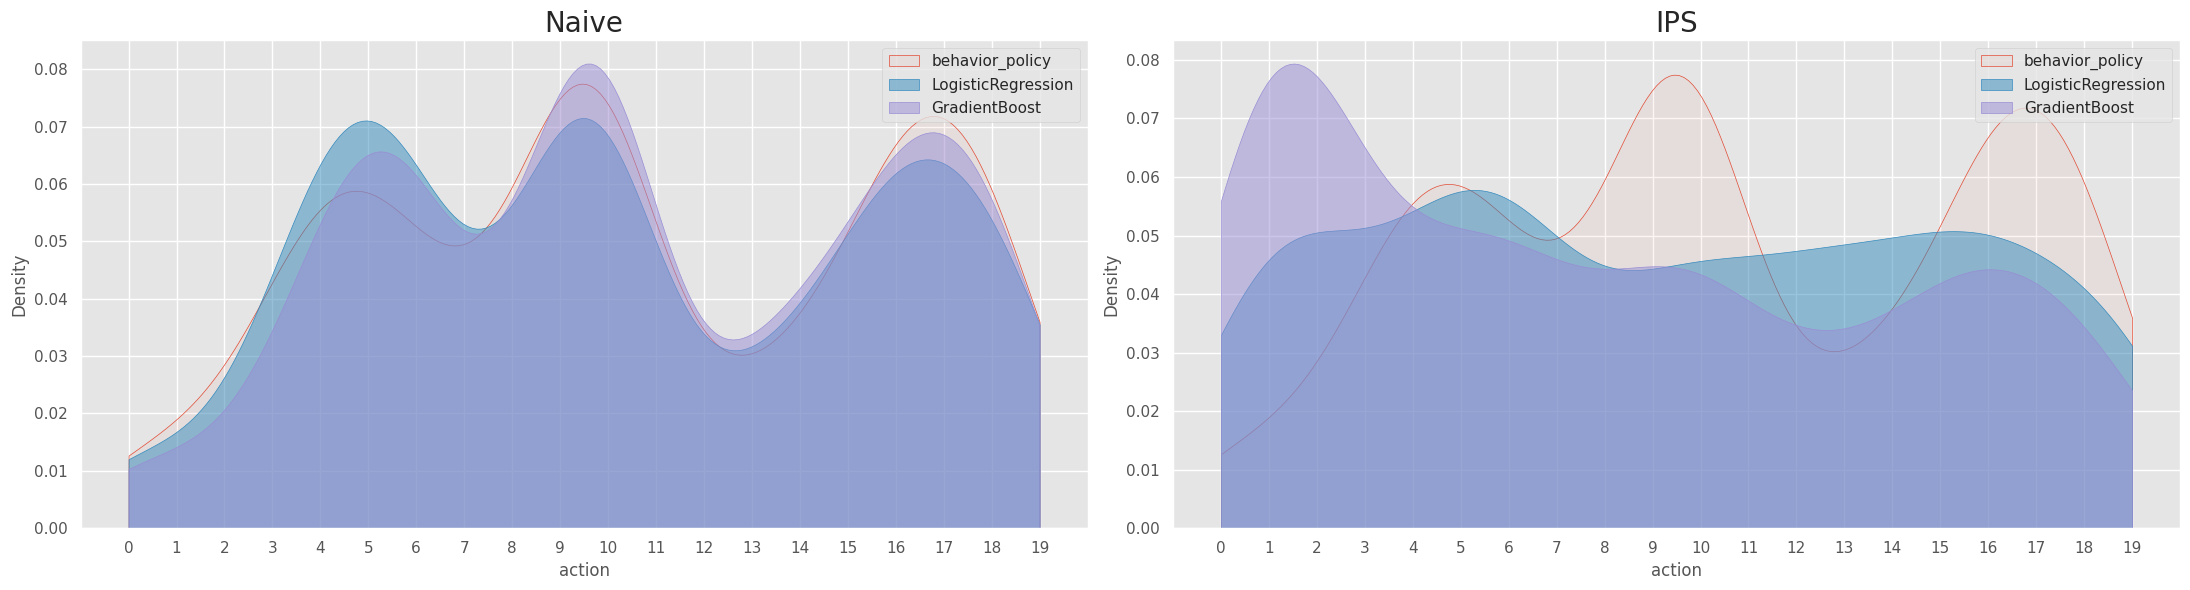

In [6]:
control = {"alpha": 0.05}
experiment = {"alpha": 0.5}
settings = {"behavior_policy": control, "LogisticRegression": experiment, "GradientBoost": experiment}
estimators = ["Naive", "IPS"]
titles = ["Naive", "IPS"]

plt.style.use("ggplot")
fig, axes = plt.subplots(1, 2, figsize=(22, 6))

for ax, estimator, title in zip(axes, estimators, titles):
    for policy, setting in settings.items():
        indicator = (result_df["estimator"] == estimator) & (result_df["policy_name"] == policy)

        sns.kdeplot(
            data=result_df[indicator], 
            x="action",
            shade=True,
            clip=[0,19],
            alpha=setting["alpha"],
            label=policy,
            ax=ax,
        )
        
        ax.set_title(title, fontsize=20)
        ax.set_xticks(np.arange(n_actions))
        ax.set_xlim([-1, 20])
        ax.legend()


plt.tight_layout()
plt.show()

In [7]:
# Off-Policy Evaluation
dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    beta=beta
)
# generate synthetic test data
test_data = dataset.obtain_batch_bandit_feedback(n_rounds=1000000)

policy_values = dict()
for estimator_name in ["IPS", "Naive"]:
    for policy_name in ["LogisticRegression", "GradientBoost"]:
        action_dist = evaluation_policies[estimator_name][policy_name].predict_score(context=test_data["context"])
        
        policy_value = dataset.calc_ground_truth_policy_value(
            expected_reward=test_data["expected_reward"],
            action_dist=action_dist
        )
        policy_values[f"{estimator_name}_{policy_name}"] = policy_value

In [8]:
policy_values

{'IPS_LogisticRegression': 0.7650683663524322,
 'IPS_GradientBoost': 0.6996860709036965,
 'Naive_LogisticRegression': 0.7580424759714061,
 'Naive_GradientBoost': 0.7099722949299798}

In [9]:
val_sizes = [1000, 3000, 5000, 7000, 9000]

dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    beta=beta
)
ips = IPS()

result_df_list = []
for val_size in val_sizes:
    result_dict_list = defaultdict(list)
    for _ in tqdm(range(100), desc=f"val_size={val_size}"):
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        for estimator_name in ["IPS", "Naive"]:
            for policy_name in ["LogisticRegression", "GradientBoost"]:
                
                action_dist = evaluation_policies[estimator_name][policy_name].predict_score(
                    context=val_data["context"]
                )
                
                estimated_value = ips.estimate_policy_value(
                    reward=val_data["reward"],
                    action=val_data["action"],
                    action_dist=action_dist,
                    pscore=val_data["pscore"] if estimator_name == "IPS" else np.ones_like(val_data["pscore"])
                )
                estimated_value_dict = dict()
                estimated_value_dict[f"{estimator_name}_{policy_name}"] = estimated_value
                result_dict_list[f"{estimator_name}_{policy_name}"].append(estimated_value_dict)
    
    for estimator_model_name, result_list in result_dict_list.items():
        # calculate MSE
        result_df = aggregate_simulation_results(
            simulation_result_list=result_list,
            policy_value=policy_values[estimator_model_name],
            x_value=val_size
        )
        result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=1000: 100% 100/100 [00:02<00:00, 41.87it/s]
val_size=3000: 100% 100/100 [00:06<00:00, 16.53it/s]
val_size=5000: 100% 100/100 [00:09<00:00, 10.47it/s]
val_size=7000: 100% 100/100 [00:12<00:00,  7.82it/s]
val_size=9000: 100% 100/100 [00:15<00:00,  6.44it/s]


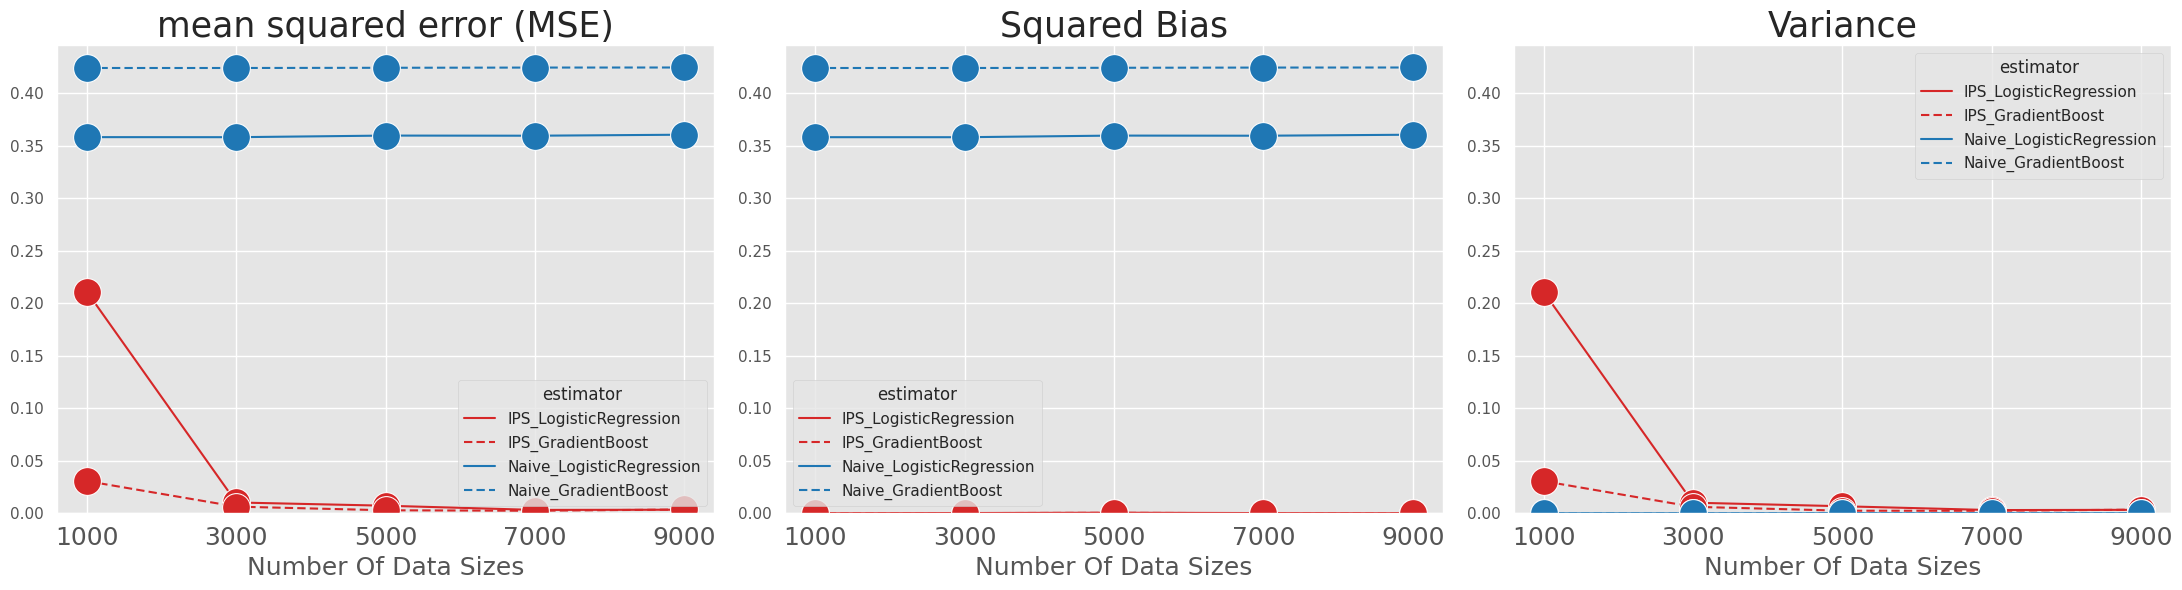

In [10]:
visualize_mean_squared_error(result_df=result_df, xlabel="Number Of Data Sizes")